In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import numpy as np
import time
import pickle as pkl
import sys

sys.path.insert(0, '..')
from livexiv.efficient_eval import *

m = 5 #number of models to re-evaluate at each step
names = ['vqa','tqa']

models_names = ['InstructBLIP-7B',
                'InternLM-Xcomposer2.5-7B',
                'InternVL2-2B',
                'InternVL2-8B',
                'LLaVA-1.6-Mistral-7B',
                'LLaVA-OneVision-Qwen2-7B',
                'LLaVA-1.5-13B',
                'LLaVA-1.6-7B',
                'LLaVA-1.6-34B',
                'Mantis-LLama3-8B',
                'Phi3v',
                'InternLM-Xcomposer2-4KHD-7B',
                'Idefics2-8B',
                'Claude-Sonnet',
                'Qwen2-VL',
                'GPT-4o',
                'Idefics3']

In [2]:
accs, accs_hat = {}, {}
models = {}

for name in names:
    Y = np.load(f"../data/{name}_by_domain_v1.pkl", allow_pickle=True)
    Y = np.hstack([v for v in Y.values()])
    Y_old = np.load(f"../data/old_papers_auto_{name}_matrix.npy", allow_pickle=True)
    models[name] = {}
    
    # eval in old version
    models[name][0] = list(range(0,len(models_names)))
    Y_list = [Y_old]
    M_list = [models[name][0]]
    reval_models, _ = EfficEval(Y_list, M_list, m)
    assert len(reval_models)==m
    
    # eval in new version
    models[name][1] = reval_models
    Y_list += [Y[models[name][1]]]
    M_list += [models[name][1]]
    _, Y_hat = EfficEval(Y_list, M_list, m)
    
    # outputs
    accs[name] = 100*Y.mean(1)
    accs_hat[name] = 100*Y_hat[1].mean(1)

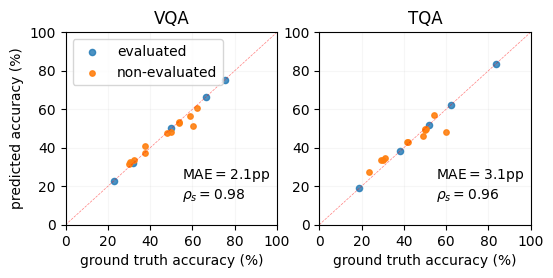

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))  # 1 row, 2 columns for side-by-side plots

for i,name in enumerate(names):
    acc, acc_hat = accs[name], accs_hat[name]
    ind = np.zeros(len(models_names)).astype(bool)
    ind[models[name][1]] = True
    axes[i].scatter(acc[ind], acc_hat[ind], s=20, alpha=.80, label='evaluated')
    axes[i].scatter(acc[~ind], acc_hat[~ind], s=15, alpha=.90, label='non-evaluated')
    axes[i].plot([0, 100], [0, 100], 'r--', lw=.5, alpha=.5)
    text = f'MAE$=${np.abs(acc-acc_hat)[~ind].mean():.1f}pp\n$\\rho_s=${spearmanr(acc, acc_hat).statistic:.2f}'
    #axes[i].text(70, 20, text, fontsize=10, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.5))
    axes[i].text(55, 13.5, text, fontsize=10, bbox=dict(facecolor='none', edgecolor='none'))
    
    axes[i].set_xlabel('ground truth accuracy (%)')
    if i==0: axes[i].set_ylabel('predicted accuracy (%)')
    axes[i].set_xlim(0,100)
    axes[i].set_ylim(0,100)
    axes[i].set_title({'vqa':'VQA','tqa':'TQA'}[name])
    axes[i].grid(alpha=.1)
    
    if i==0: axes[i].legend()
plt.savefig(f'../plots/v1_from_old.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()